<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Імпорти </h2> </div>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


import os
import PIL
import torch
import random
import pandas as pd
from torch import nn
from PIL import Image
import seaborn as sns
from tqdm.auto import tqdm
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from typing import Optional, List, Any, Tuple

<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Константи </h2> </div>

In [2]:
CARTOON_FACES_DATASET_PATH = "./datasets/cartoonset100k_jpg"
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 128
NOISE_SIZE = 256
GENERATOR_LEARNING_RATE = 0.0002 * (BATCH_SIZE / 128)
DISCRIMINATOR_LEARNING_RATE = 0.0001 * (BATCH_SIZE / 128)
BETA_1 = 0.0
BETA_2 = 0.9
NUM_EPOCHS = 200
SAVE_GENERATOR_DIRECTORY = "E:/dcgan_wgan_gp_4_checkpoints"
SAVE_DISCRIMINATOR_DIRECTORY = "E:/dcgan_wgan_gp_4_checkpoints"
SAVE_GENERATOR_PER_EPOCH = 4
SAVE_DISCRIMINATOR_PER_EPOCH = 4
SAVE_FAKE_IMAGES_PATH = "./fake_images/dcgan_wgan_gp_4"
SAVE_LOGS_PATH = "./logs/dcgan_wgan_gp_4/gan_training_logs.csv"

<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Датасет </h2> </div>

В роботі використовувся <a href="https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set">Cartoon Faces (Google's Cartoon Set)</a> датасет.</br>
Він містить 100 тисяч зображень.</br>
Всі зображення поділенні випадковим чином на 10 папок.</br>
В роботі буде використовуватися лише одна папка (10 тисяч зображень).

Клас датасету

In [3]:
class CartoonFacesDataset(Dataset):
    def __init__(self,
                 root,
                 transform=None,
                 include_folders: Optional[List[str]] = None,
                 load_in_memory: bool = True,
                 device: Optional[torch.device] = None):
        self.root = root
        self.transform = transform
        self.load_in_memory = load_in_memory
        self.device = device
        if include_folders is None:
            self.folders = [d for d in os.listdir(self.root) if os.path.isdir(os.path.join(self.root, d))]
        else:
            self.folders = include_folders
        self.data = []
        for folder in self.folders:
            images_folder = os.path.join(self.root, folder)
            for file_name in os.listdir(images_folder):
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    image_path = os.path.join(images_folder, file_name)
                    if self.load_in_memory:
                        image = Image.open(image_path).convert("RGB")
                        if self.transform:
                            image = self.transform(image)
                            if self.device:
                                image = image.to(self.device)
                        self.data.append(image)
                    else:
                        self.data.append(image_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,
                    idx: int):
        if self.load_in_memory:
            image = self.data[idx]
        else:
            image_path = self.data[idx]
            image = Image.open(image_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
                if self.device:
                    image = image.to(self.device)
        return image

Створення об'єкту датасету

In [4]:
cartoon_faces_dataset = CartoonFacesDataset(root=CARTOON_FACES_DATASET_PATH, include_folders=["0"], load_in_memory=False)

Виведення зразків зображень в датасеті

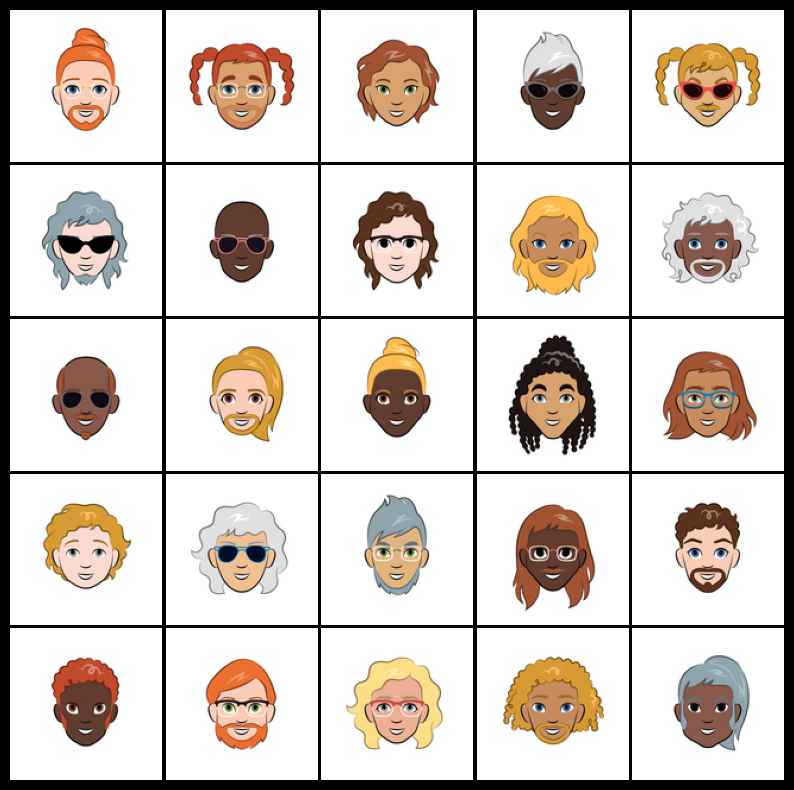

In [5]:
random.seed(42)
random_images_idx = [random.randint(0, len(cartoon_faces_dataset) - 1) for _ in range(25)]
plt.figure(figsize=(10, 10), facecolor='black')
plt.subplots_adjust(wspace=0.02, hspace=0.02)
for i, image_idx in enumerate(random_images_idx):
    image = cartoon_faces_dataset[image_idx]
    image = image.resize(IMAGE_SIZE, resample=Image.LANCZOS)
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.axis("off")
plt.show()

Визначаємо чи доступна відеокарта

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Завантаження датасету в оперативну пам'ять для подальшого тренування

In [7]:
transform = transforms.Compose([
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
cartoon_faces_dataset = CartoonFacesDataset(root=CARTOON_FACES_DATASET_PATH,
                                            include_folders=["0"],
                                            transform=transform)

<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Генератор і Дискримінатор </h2> </div>

Для визначення і створення архітектур генератора і дискримінатора використовувались такі роботи: <a href="https://arxiv.org/abs/1511.06434">DCGAN</a>, <a href="https://arxiv.org/abs/1701.07875">WGAN</a>, <a href="https://arxiv.org/pdf/1704.00028">WGAN with GP</a></br>
WGAN - це підхід до тренування GAN, який збільшує стабільність навчання та запобігає "mode collapse"</br>
WGAN використовує метрику Вассерштейна для обчислення функції втрат (loss)</br>
Gradient Penalty - один із найкращих способів обчислення втрат за допомогою метрики Вассерштейна

Функція для ініціалізації ваг моделей за нормальним розподілом

In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Клас генератору

In [5]:
class Generator(nn.Module):
    def __init__(self,
                 noise_size: int = 256,
                 feature_maps_size: int = 128,
                 image_channels: int = 3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_size, feature_maps_size * 16, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_maps_size * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps_size * 16, feature_maps_size * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps_size * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps_size * 8, feature_maps_size * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps_size * 4, feature_maps_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps_size * 2, feature_maps_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps_size, image_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        return self.main(input_tensor)

Створення генератору

In [10]:
generator = Generator(noise_size=NOISE_SIZE).to(device)
generator.apply(weights_init_normal)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(256, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

Клас дискримінатора

In [11]:
class Discriminator(nn.Module):
    def __init__(self,
                 feature_maps_size: int = 64,
                 image_channels: int = 3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(image_channels, feature_maps_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(feature_maps_size, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_size, feature_maps_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(feature_maps_size * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_size * 2, feature_maps_size * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(feature_maps_size * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_size * 4, feature_maps_size * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(feature_maps_size * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_size * 8, feature_maps_size * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(feature_maps_size * 16, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_size * 16, 1, kernel_size=4, stride=1, padding=0, bias=False)
        )

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        out = self.main(input_tensor)
        return out.squeeze()

Створення дискримінатору

In [12]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init_normal)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 

<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Тренування </h2> </div>

Функції для тренування

In [11]:
def tensors_to_images(tensor: torch.Tensor) -> List[PIL.Image.Image]:
    to_pil = ToPILImage()
    return [to_pil((fake_image + 1) / 2) for fake_image in tensor]


def save_checkpoint(model: nn.Module,
                    optimizer: Any = None,
                    scheduler: Any = None,
                    epoch: Optional[int] = None,
                    path: str = None) -> None:
    checkpoint = {}
    checkpoint["model_state_dict"] = model.state_dict()
    if optimizer is not None:
        checkpoint["optimizer_state_dict"] = optimizer.state_dict()
    if scheduler is not None:
        checkpoint["scheduler_state_dict"] = scheduler.state_dict()
    if epoch is not None:
        checkpoint["epoch"] = epoch
    torch.save(checkpoint, path)


def load_checkpoint(model: nn.Module,
                    optimizer: Any = None,
                    scheduler: Any = None,
                    path: str = None) -> int:
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer is not None and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler is not None and "scheduler_state_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    if "epoch" in checkpoint:
        return checkpoint["epoch"]
    return 0


def gradient_penalty(discriminator, real_images, fake_images, device):
    batch_size = real_images.size(0)
    eps = torch.rand(batch_size, 1, 1, 1, device=device, requires_grad=True)
    inter = eps * real_images + (1 - eps) * fake_images
    d_inter = discriminator(inter)
    grads = torch.autograd.grad(outputs=d_inter,
                                inputs=inter,
                                grad_outputs=torch.ones_like(d_inter),
                                create_graph=True,
                                retain_graph=True)[0]
    grads = grads.view(batch_size,-1)
    gp = ((grads.norm(2,dim=1)-1)**2).mean()
    return gp


def train_gan(generator: nn.Module,
              discriminator: nn.Module,
              dataloader: DataLoader,
              generator_optimizer: Any,
              discriminator_optimizer: Any,
              num_epochs: int,
              discriminator_iteration_per_batch: int = 1,
              noise_size: int = 128,
              gp_lambda: float = 10.0,
              fixed_noises: torch.Tensor = None,
              save_fake_images_path: Optional[str] = None,
              save_generator_directory: Optional[str] = None,
              save_discriminator_directory: Optional[str] = None,
              save_generator_per_epoch: int = 1,
              save_discriminator_per_epoch: int = 1,
              load_generator_checkpoint_path: Optional[str] = None,
              load_discriminator_checkpoint_path: Optional[str] = None,
              log_file_path: Optional[str] = None,
              show_fake_images: bool = True,
              fake_images_grid_size: Optional[Tuple[int, int]] = None,
              fake_images_figure_size: Optional[Tuple[int, int]] = None,
              verbose: bool = True) -> pd.DataFrame:
    start_epoch = 0
    device = next(generator.parameters()).device
    if load_generator_checkpoint_path is not None:
        start_epoch = load_checkpoint(generator,
                                      optimizer=generator_optimizer,
                                      path=load_generator_checkpoint_path)
    if load_discriminator_checkpoint_path is not None:
        start_epoch = load_checkpoint(discriminator,
                                      optimizer=discriminator_optimizer,
                                      path=load_discriminator_checkpoint_path)
    result_df = pd.DataFrame(columns=["epoch", "batch", "generator_loss", "discriminator_loss", "discriminator_real_loss", "discriminator_fake_loss", "w_gap", "gradient_penalty", "drift_penalty"])
    for epoch in range(start_epoch, num_epochs):
        generator_running_loss = 0.0
        discriminator_running_loss = 0.0
        w_gap = 0.0
        pbar = tqdm(dataloader, total=len(dataloader), disable=not verbose)
        pbar.set_description(f"Epoch: {epoch+1}/{num_epochs} Generator Loss: {generator_running_loss:.4f} Discriminator Loss: {discriminator_running_loss:.4f} Wasserstein gap: {w_gap:.4f}")
        generator.train()
        discriminator.train()
        for i, real_images in enumerate(pbar):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            discriminator_loss = None
            discriminator_real_loss = None
            discriminator_fake_loss = None
            drift_penalty = None
            gp = None
            for _ in range(discriminator_iteration_per_batch):
                noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
                fake_images = generator(noise).detach()
                discriminator_optimizer.zero_grad()
                real_output = discriminator(real_images)
                fake_output = discriminator(fake_images)
                discriminator_real_loss = real_output.mean()
                discriminator_fake_loss = fake_output.mean()
                gp = gradient_penalty(discriminator, real_images, fake_images, device)
                drift_penalty = 0.001 * torch.mean(real_output ** 2)
                discriminator_loss = (
                    discriminator_fake_loss
                    - discriminator_real_loss
                    + gp_lambda * gp
                    + drift_penalty
                )
                discriminator_loss.backward()
                discriminator_optimizer.step()
                w_gap = discriminator_real_loss.item() - discriminator_fake_loss.item()

            noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
            generator_optimizer.zero_grad()
            fake_images = generator(noise)
            output = discriminator(fake_images)
            generator_loss = -output.mean()
            generator_loss.backward()
            generator_optimizer.step()

            discriminator_running_loss = discriminator_loss.item() if discriminator_loss is not None else 0
            generator_running_loss = generator_loss.item()
            pbar.set_description(f"Epoch: {epoch+1}/{num_epochs} Generator Loss: {generator_running_loss:.4f} Discriminator Loss: {discriminator_running_loss:.4f} Wasserstein gap: {w_gap:.4f}")
            result_df.loc[len(result_df)] = [
                epoch + 1,
                i + 1,
                generator_running_loss,
                discriminator_running_loss,
                discriminator_real_loss.item() if discriminator_real_loss is not None else 0,
                discriminator_fake_loss.item() if discriminator_fake_loss is not None else 0,
                w_gap,
                gp.item() if gp is not None else 0,
                drift_penalty.item() if drift_penalty is not None else 0
            ]

        generator.eval()
        discriminator.eval()
        if log_file_path is not None:
            result_df.to_csv(log_file_path, index=False)
        if save_generator_directory is not None:
            if (epoch + 1) % save_generator_per_epoch == 0:
                save_generator_checkpoint_path = os.path.join(save_generator_directory, f"generator_checkpoint_{epoch+1}.pth")
                save_checkpoint(generator, optimizer=generator_optimizer, epoch=epoch + 1, path=save_generator_checkpoint_path)
        if save_discriminator_directory is not None:
            if (epoch + 1) % save_discriminator_per_epoch == 0:
                save_discriminator_checkpoint_path = os.path.join(save_discriminator_directory, f"discriminator_checkpoint_{epoch+1}.pth")
                save_checkpoint(discriminator, optimizer=discriminator_optimizer, epoch=epoch + 1, path=save_discriminator_checkpoint_path)
        if fixed_noises is not None:
            with torch.no_grad():
                fake_images = generator(fixed_noises.to(device)).detach().cpu()
            fake_images = tensors_to_images(fake_images)
            if save_fake_images_path is not None:
                epoch_dir = os.path.join(save_fake_images_path, f"{epoch+1}")
                os.makedirs(epoch_dir, exist_ok=True)
                for i, fake_image in enumerate(fake_images):
                    fake_image.save(os.path.join(epoch_dir, f"{i}.png"))
            if show_fake_images and fake_images_grid_size is not None:
                rows, cols = fake_images_grid_size
                if fake_images_figure_size is not None:
                    plt.figure(figsize=fake_images_figure_size, facecolor='black')
                else:
                    plt.figure(figsize=(cols, rows), facecolor='black')
                plt.subplots_adjust(wspace=0.02, hspace=0.02)
                for i, fake_image in enumerate(fake_images):
                    plt.subplot(rows, cols, i+1)
                    plt.imshow(fake_image)
                    plt.axis("off")
                plt.show()
    return result_df

Створення даталоадеру

In [14]:
dataloader = torch.utils.data.DataLoader(cartoon_faces_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, pin_memory_device=str(device))

Створення оптимізаторів та фіксованого шуму

In [15]:
generator_optimizer = optim.Adam(generator.parameters(), lr=GENERATOR_LEARNING_RATE, betas=(BETA_1, BETA_2))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=DISCRIMINATOR_LEARNING_RATE, betas=(BETA_1, BETA_2))
g = torch.Generator(device=device.type).manual_seed(42)
fixed_noises = torch.randn(16, NOISE_SIZE, 1, 1, generator=g, device=device)

Тренування

In [1]:
result_df = train_gan(generator=generator,
                      discriminator=discriminator,
                      dataloader=dataloader,
                      generator_optimizer=generator_optimizer,
                      discriminator_optimizer=discriminator_optimizer,
                      num_epochs=NUM_EPOCHS,
                      noise_size=NOISE_SIZE,
                      fixed_noises=fixed_noises,
                      save_generator_directory=SAVE_GENERATOR_DIRECTORY,
                      save_discriminator_directory=SAVE_DISCRIMINATOR_DIRECTORY,
                      save_generator_per_epoch=SAVE_GENERATOR_PER_EPOCH,
                      save_discriminator_per_epoch=SAVE_DISCRIMINATOR_PER_EPOCH,
                      save_fake_images_path=SAVE_FAKE_IMAGES_PATH,
                      log_file_path=SAVE_LOGS_PATH,
                      show_fake_images = True,
                      fake_images_grid_size = (4, 4),
                      fake_images_figure_size=(8, 8))

NameError: name 'train_gan' is not defined

<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Результати тренування </h2> </div>

Функція для відмалювання графіків

In [17]:
def show_training_results(df: pd.DataFrame,
                          xlabel: str,
                          aggregate_fn: Optional[str] = None):
    function_label = ""
    if aggregate_fn:
        if aggregate_fn == "mean":
            df = df.groupby("epoch")[["generator_loss", "discriminator_loss", "discriminator_real_loss", "discriminator_fake_loss", "w_gap", "gradient_penalty", "drift_penalty"]].mean().reset_index()
            function_label = " Mean"
        if aggregate_fn == "min":
            df = df.groupby("epoch")[["generator_loss", "discriminator_loss", "discriminator_real_loss", "discriminator_fake_loss", "w_gap", "gradient_penalty", "drift_penalty"]].min().reset_index()
            function_label = " Min"
        if aggregate_fn == "max":
            df = df.groupby("epoch")[["generator_loss", "discriminator_loss", "discriminator_real_loss", "discriminator_fake_loss", "w_gap", "gradient_penalty", "drift_penalty"]].max().reset_index()
            function_label = " Max"

    plt.figure(figsize=(18,10))
    sns.set_style("darkgrid")

    plt.subplot(2, 2, 1)
    plt.title(f"Generator Loss{function_label}",fontsize=15)
    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel("Loss",fontsize=12)
    plt.plot(df["generator_loss"])

    plt.subplot(2, 2, 2)
    plt.title(f"Discriminator Loss{function_label}",fontsize=15)
    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel("Loss",fontsize=12)
    plt.plot(df["discriminator_loss"])

    plt.subplot(2, 2, 3)
    plt.title(f"Wasserstein Gap{function_label}",fontsize=15)
    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel("Wasserstein Gap",fontsize=12)
    plt.plot(df["w_gap"])

    plt.subplot(2, 2, 4)
    plt.title(f"Gradient Penalty{function_label}",fontsize=15)
    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel("Gradient Penalty",fontsize=12)
    plt.plot(df["gradient_penalty"])

    plt.show()

Generator Loss, Discriminator Loss, Wasserstein Gap, Gradient Penalty за ітераціями

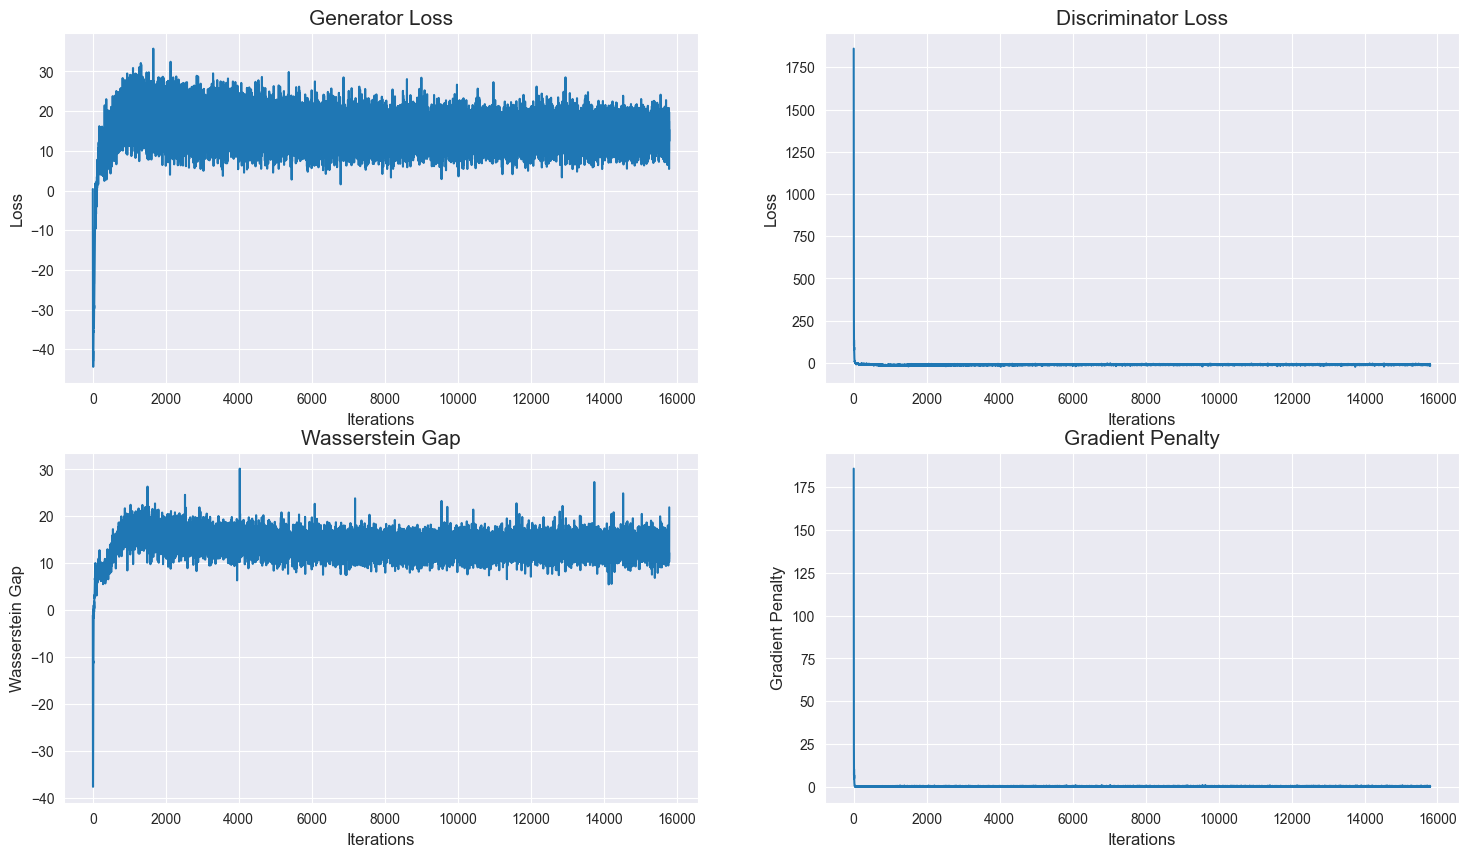

In [18]:
show_training_results(result_df, "Iterations")

Середні Generator Loss, Discriminator Loss, Wasserstein Gap, Gradient Penalty за епохами

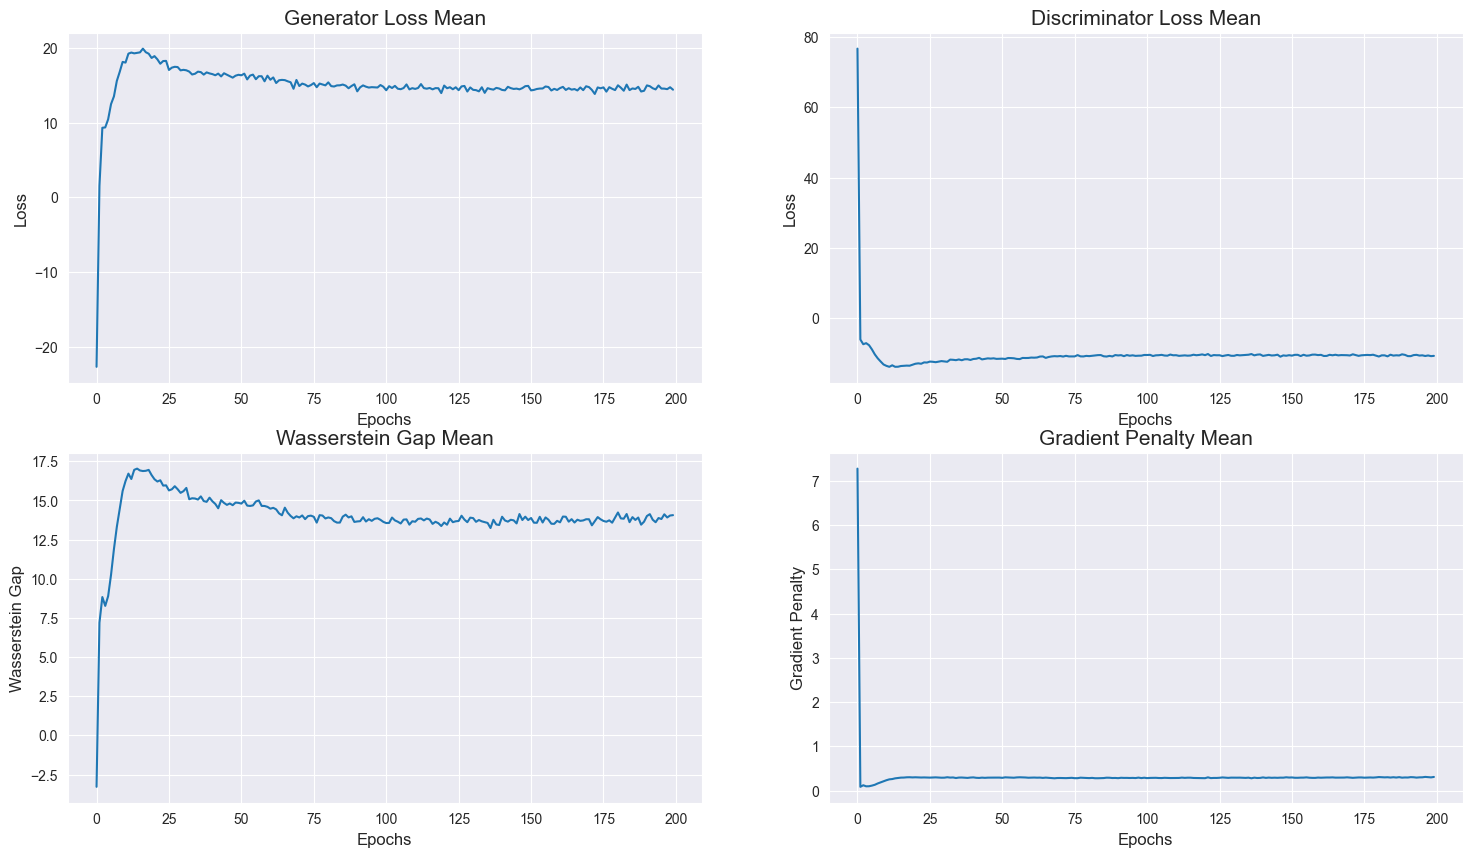

In [19]:
show_training_results(result_df, "Epochs", aggregate_fn="mean")

Мінімальні Generator Loss, Discriminator Loss, Wasserstein Gap, Gradient Penalty за епохами

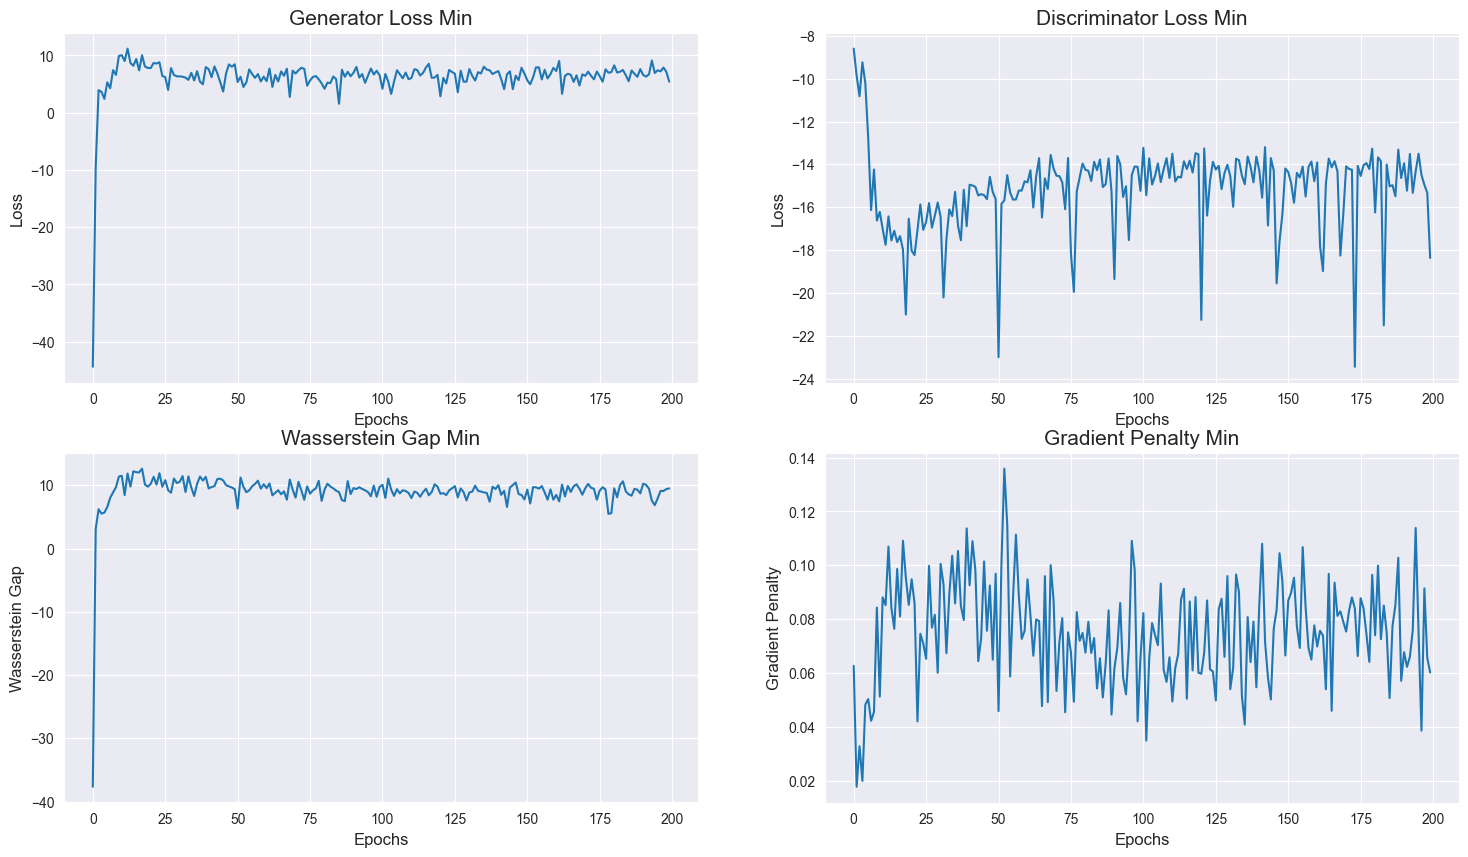

In [20]:
show_training_results(result_df, "Epochs", aggregate_fn="min")

Максимальні Generator Loss, Discriminator Loss, Wasserstein Gap, Gradient Penalty за епохами

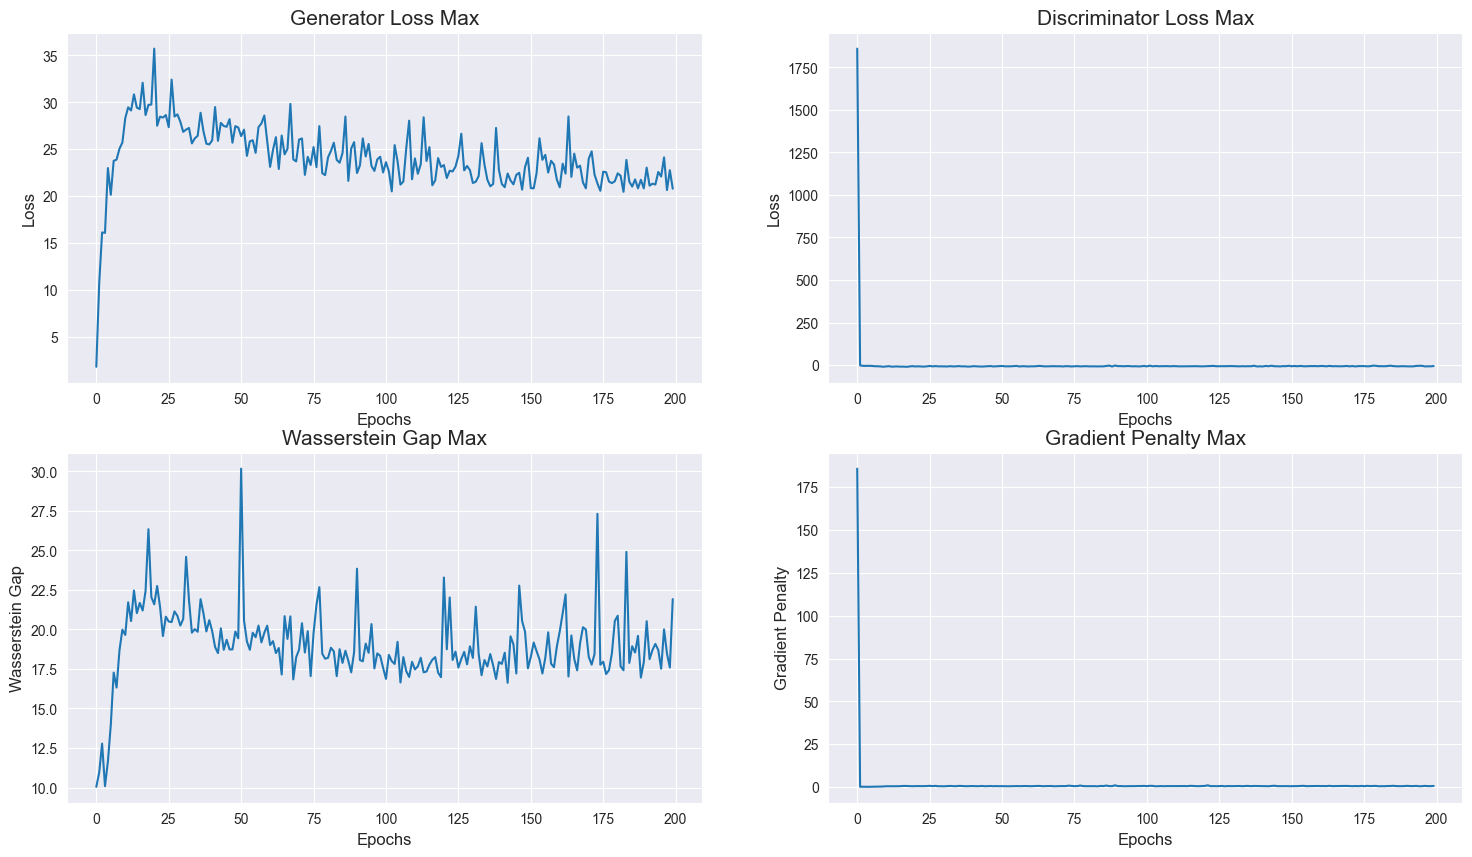

In [21]:
show_training_results(result_df, "Epochs", aggregate_fn="max")

Відмальовування змін генерованих зображень за епохами

In [2]:
images = []
for i in range(1, 201):
    for j in range(0, 16):
        image_path = os.path.join(SAVE_FAKE_IMAGES_PATH, str(i), f"{j}.png")
        image = Image.open(image_path)
        images.append(image)

for i in range(NUM_EPOCHS // 20):
    plt.figure(figsize=(32, NUM_EPOCHS // 10 * 2), facecolor='black')
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    for j in range(i * 16 * 20, (i + 1) * 16 * 20):
        plt.subplot(20, 16, j + 1 - i * 20 * 16)
        plt.imshow(images[j])
        if j % 16 == 0:
            plt.ylabel(f"Epoch: {(j + 16) // 16}", fontsize=12, color="white")
        plt.yticks([])
        plt.xticks([])
    plt.show()

NameError: name 'os' is not defined

Відмальовування 100 згенерованих зображень останньою (200-ою) епохою

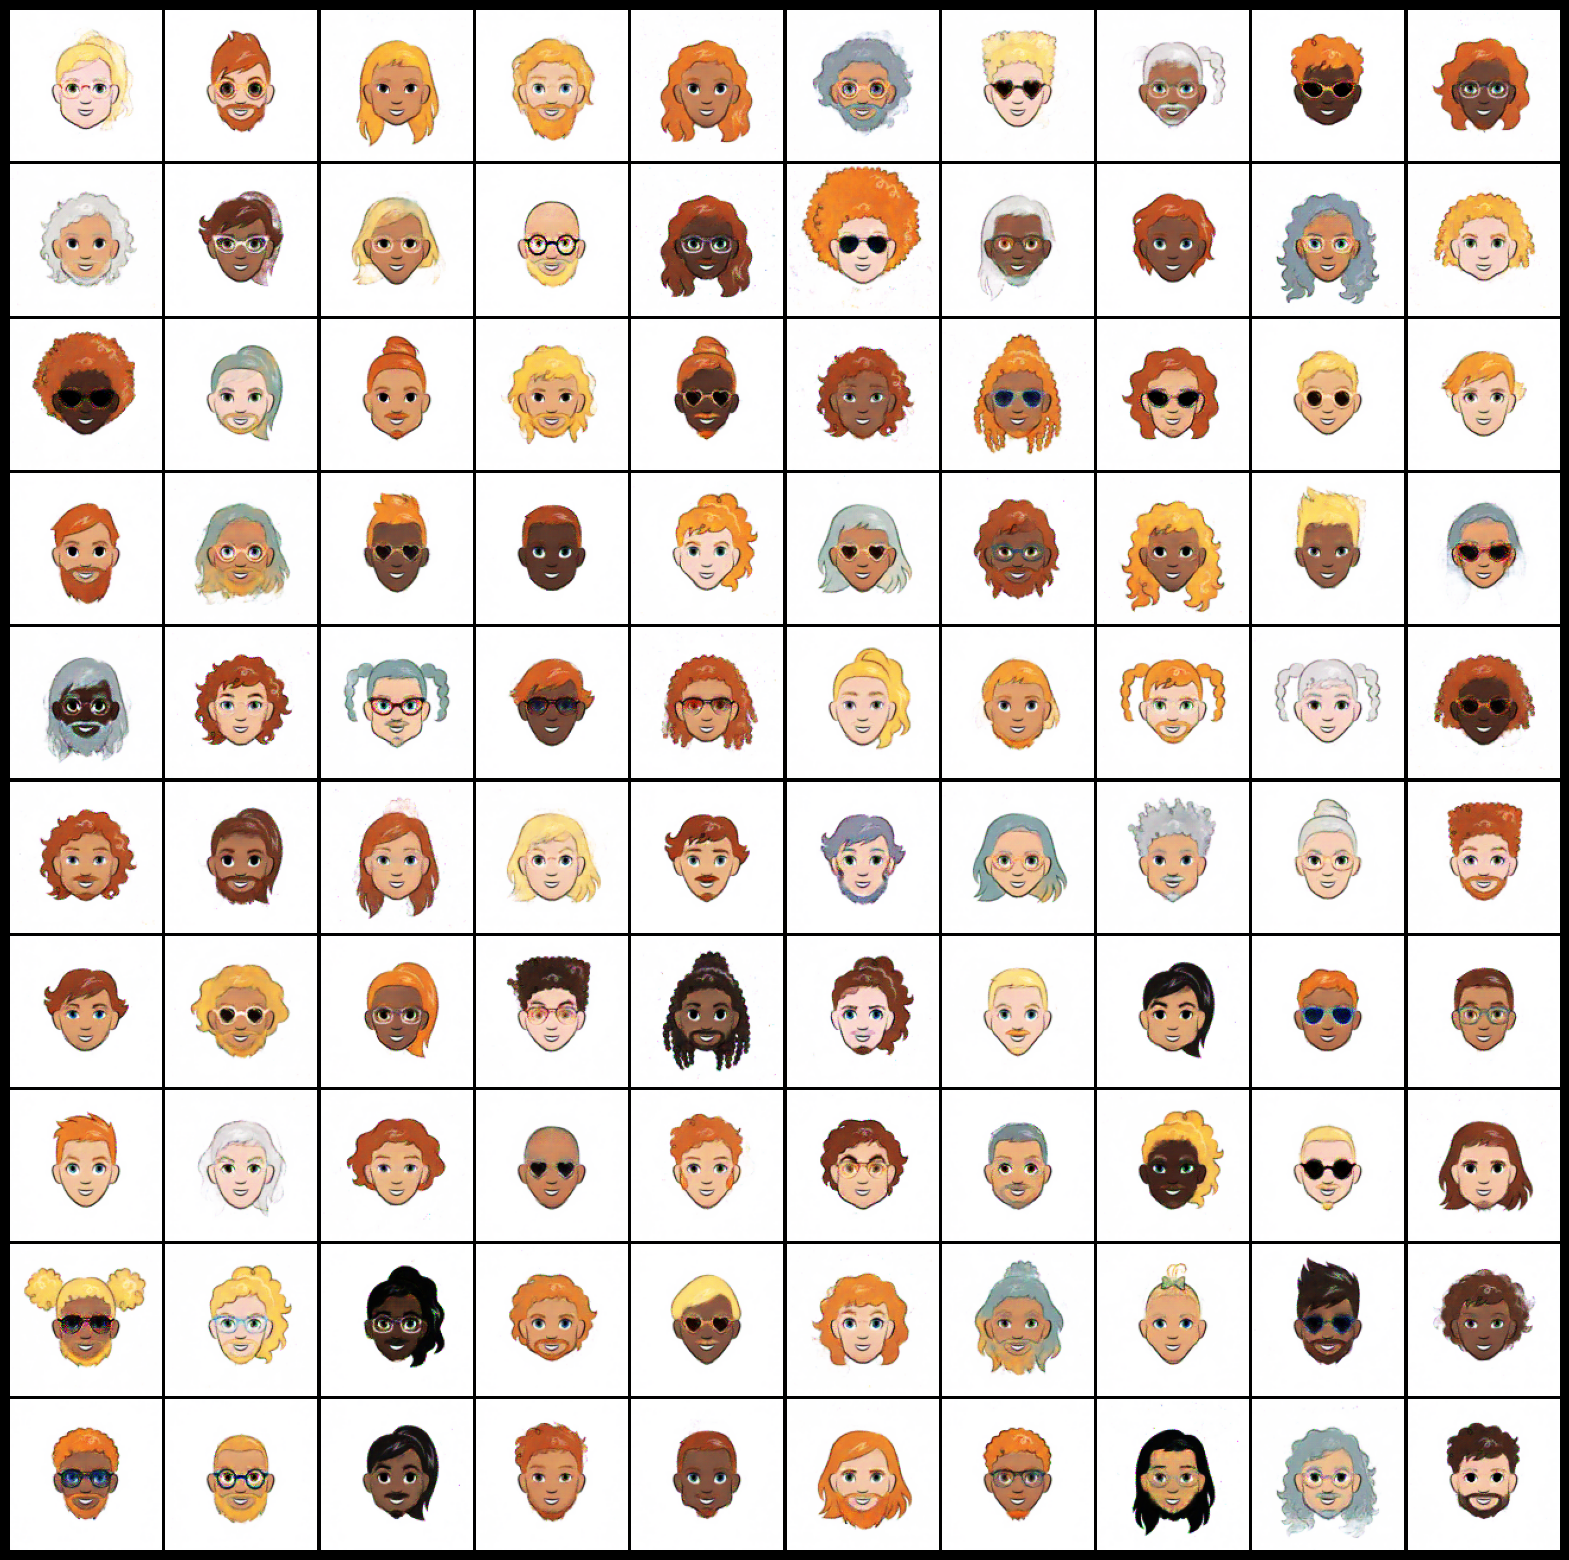

In [16]:
g = torch.Generator(device=device.type).manual_seed(2)
random_noise = torch.randn(100, NOISE_SIZE, 1, 1, device=device, generator=g)
with torch.no_grad():
    generated_images = generator(random_noise)
    images = tensors_to_images(generated_images)
plt.figure(figsize=(20, 20), facecolor='black')
plt.subplots_adjust(wspace=0.02, hspace=0.02)
for i, image in enumerate(images):
    plt.subplot(10, 10, i + 1)
    plt.imshow(image)
    plt.axis("off")
plt.show()

<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Висновок </h2> </div>

В роботі було створено, використано і натреновано  DCGAN + WGAN with GP для генерування мультяшних зображень. В результаті генератор генерує дуже схожі зображення на оригінальні, розміром 128х128 пікселів. Зображення доволі різноманітні, генератор навіть може комбінувати різні характеристики, наприклад, декілька стилів зачісок в одну або використовування декількох кольрів для зачісок. На жаль, на деяких зображення видно неповністю промальовані зачіски або інші риси. Найімовірніше, використання Progressive GAN або збільшення епох тренування зможе прибрати ці дефекти.